(1192, 1192)


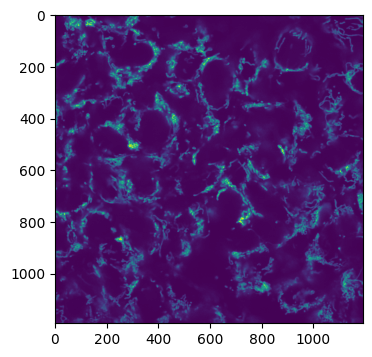

In [1]:
import skimage
import czifile
import numpy as np
import matplotlib.pyplot as plt

# read the single example image
image_path = r'data\ADAM_01.czi'
image = czifile.imread(image_path)
image = np.squeeze(image)

print(image.shape)

fig, ax = plt.subplots(figsize=(4, 4))
ax.imshow(image)
plt.show()

Methods for Image Filtering

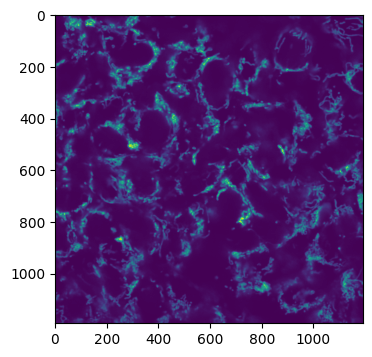

In [2]:
# gaussian filter
f_gaussian = skimage.filters.gaussian(image)
fig, ax = plt.subplots(figsize=(4, 4))
ax.imshow(f_gaussian)
plt.show()

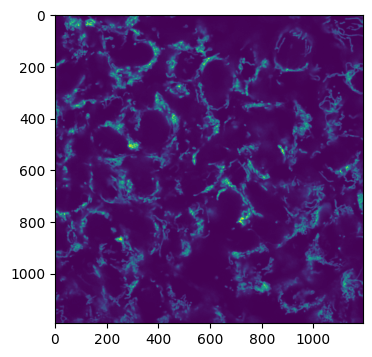

In [4]:
# median filter
f_median = skimage.filters.median(image)
fig, ax = plt.subplots(figsize=(4, 4))
ax.imshow(f_median)
plt.show()

Methods for image adjustment

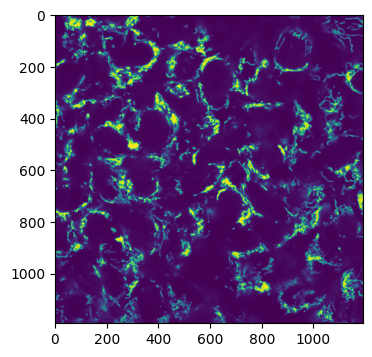

In [ ]:
# adjust with the sigmoid method
c_a_sigmoid = skimage.exposure.adjust_sigmoid(image, cutoff=0.25)
fig, ax = plt.subplots(figsize=(4, 4))
ax.imshow(c_a_sigmoid)
plt.show()

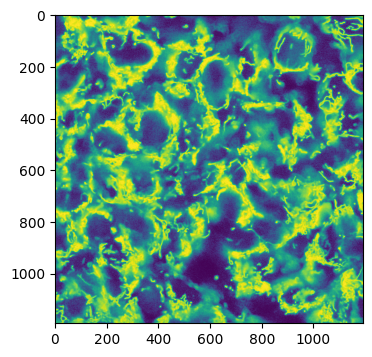

In [3]:
# adjust image with histogram equalization\
c_a_hist = skimage.exposure.equalize_hist(image)
fig, ax = plt.subplots(figsize=(4, 4))
ax.imshow(c_a_hist)
plt.show()

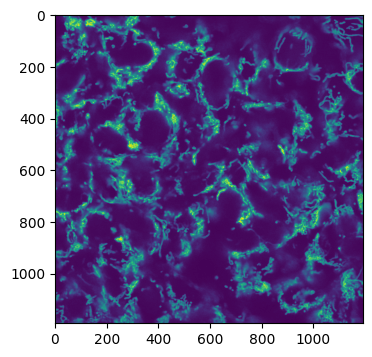

In [4]:
# adjust with contrast limited adaptive histogram equalization - for local contrast enhancement
c_a_adaptive = skimage.exposure.equalize_adapthist(image)
fig, ax = plt.subplots(figsize=(4, 4))
ax.imshow(c_a_adaptive)
plt.show()

Methods for generating a threshold - will work with the contrast adjusted sigmoid image for these

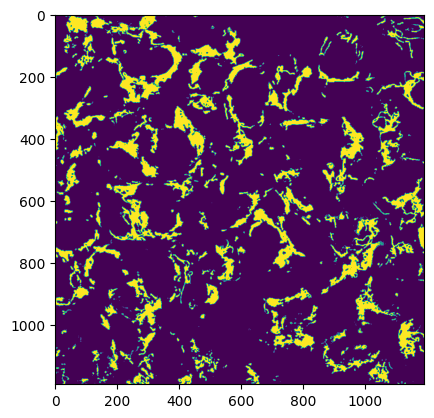

In [ ]:
# manual selection after normalization

# Normalize the pixel values in confocal_img to a range of 0 to 1
normed_image = (c_a_sigmoid - c_a_sigmoid.min()) / (c_a_sigmoid.max() - c_a_sigmoid.min()) 
# threshold the image
threshold_manual = 0.19  # adjust this value as needed
manual_thresh_imgae = normed_image > threshold_manual
# show image
plt.imshow(manual_thresh_imgae)
plt.show()


23828.162254706374
4923.755063820324


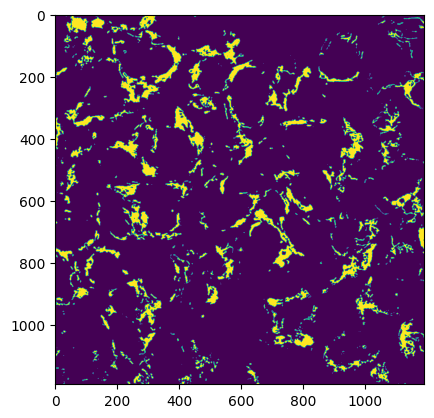

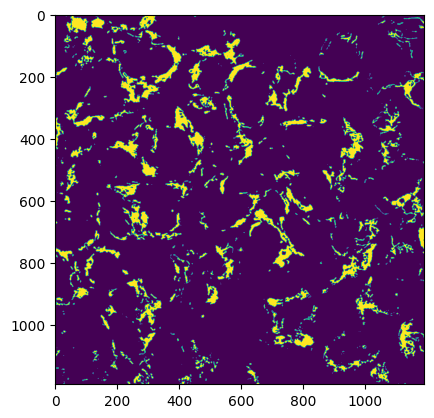

In [ ]:
# otsu thresholding (more dynamic)
threshold_otsu = skimage.filters.threshold_otsu(c_a_sigmoid)
otsu_mask = c_a_sigmoid > threshold_otsu

plt.imshow(otsu_mask)
plt.show()


Optional Cellpose intracellular segmentation

In [ ]:
# import cellpose
from cellpose import models, utils, io
# load the model
model = models.Cellpose(gpu=False, model_type='cyto')

c:\Users\bensa\AppData\Local\Programs\Python\Python312\Lib\site-packages\cellpose\resnet_torch.py:280: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(

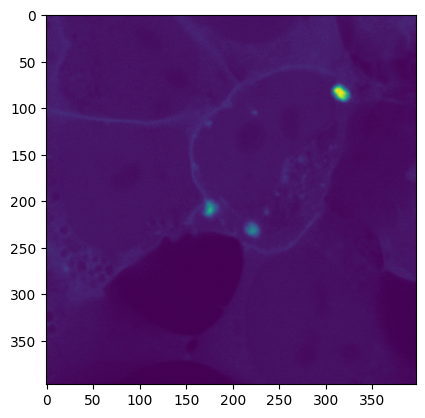

NameError: name 'model' is not defined

In [3]:
# read a slice of an image with the cell body showing
frap_image_file_path = r'data\Dox_TMRM_25nM_3hrs_FRAP_07.czi'
frap_image = czifile.imread(frap_image_file_path)
frap_image = np.squeeze(frap_image)
frap_slice = frap_image[0,:,:] 

plt.imshow(frap_slice)
plt.show()

# use cellpose to segment cells
cellpose_masks, flows, styles, diams = model.eval(frap_slice, diameter=120) # 64 is also good

# print the cellpose masks
plt.imshow(cellpose_masks)
plt.show()

print(cellpose_masks.max())

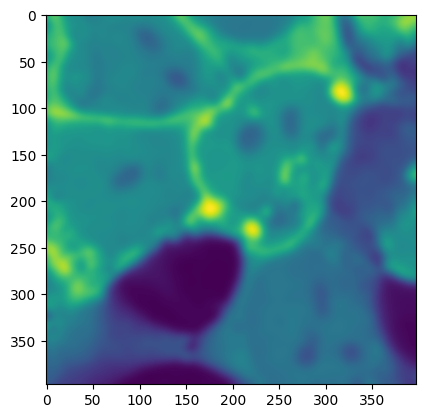

In [45]:
#pre processing image prior to cellpose segmentation - this removed inclusions so that cellpose can better segment images
frap_slice_normalized = (frap_slice - np.min(frap_slice)) / (np.max(frap_slice) - np.min(frap_slice))
# percentile for brightest pictures
p99 = np.percentile(frap_slice_normalized, 99)
# remove inclusions
frap_slice_no_inclusions = np.where(frap_slice_normalized < p99, frap_slice_normalized, p99)
frap_slice_no_inclusions = skimage.filters.gaussian(frap_slice_no_inclusions, sigma=5)

# normalize again
frap_slice_no_inclusions = (frap_slice_no_inclusions - np.min(frap_slice_no_inclusions)) / (np.max(frap_slice_no_inclusions) - np.min(frap_slice_no_inclusions))


plt.imshow(frap_slice_no_inclusions)
plt.show()


Code for segmenting components from individual cells

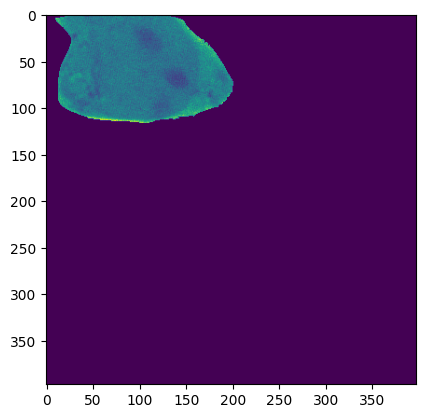

custom thresh
3


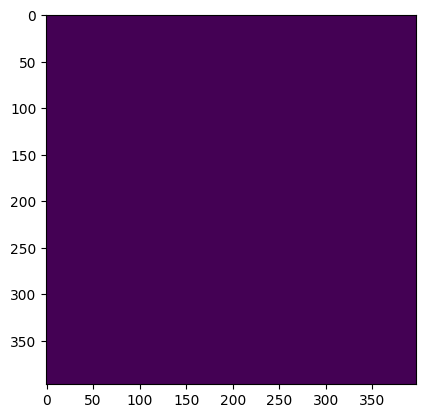

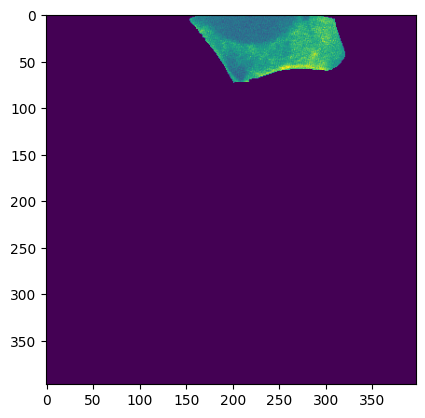

0.999


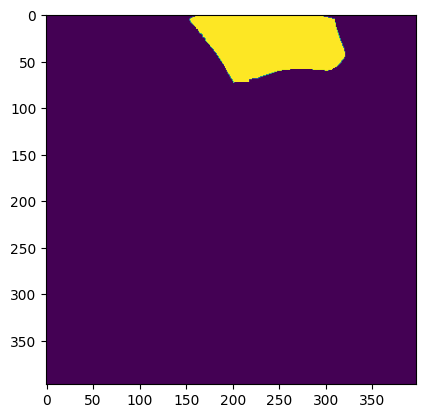

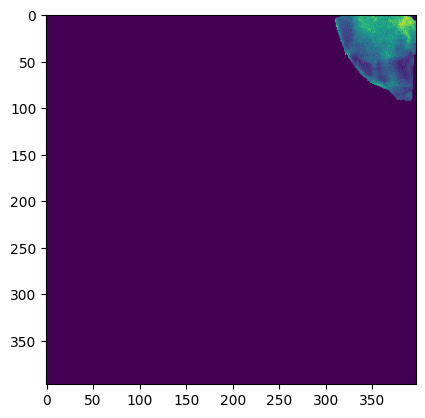

0.999


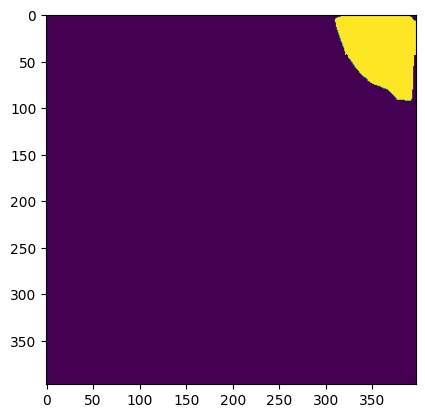

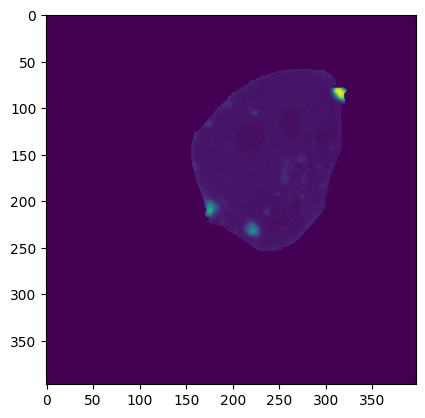

custom thresh
37


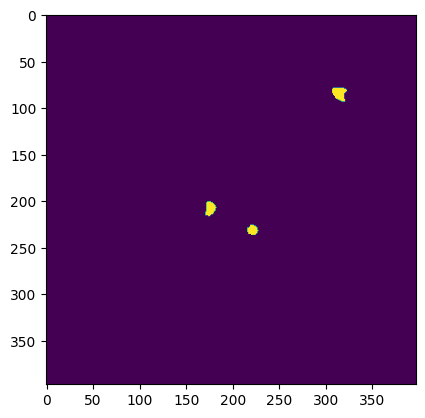

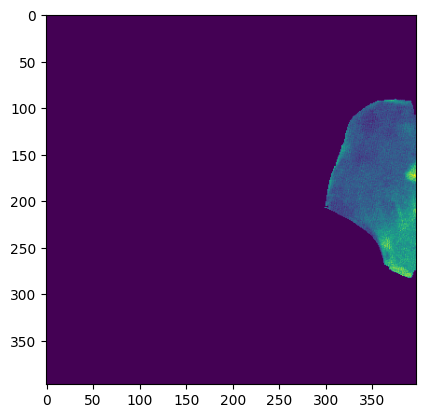

custom thresh
2


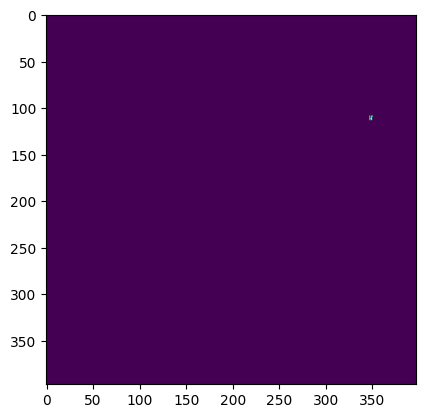

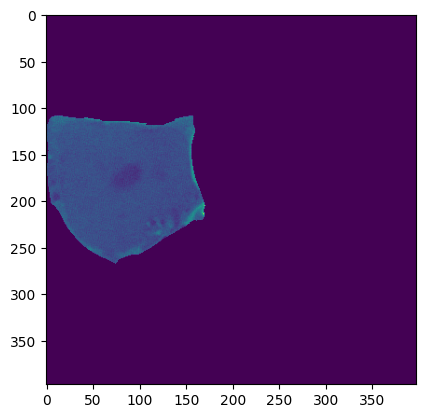

custom thresh
4


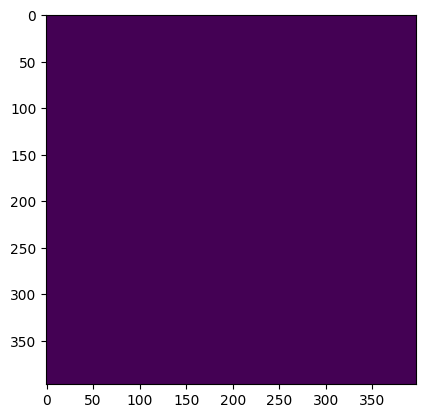

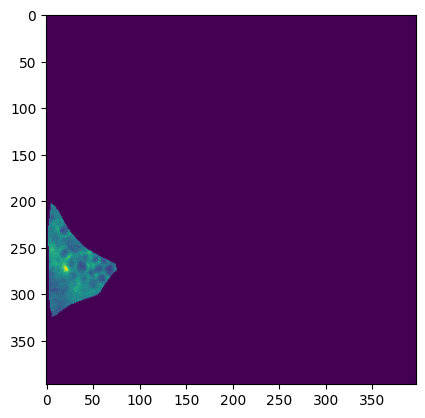

custom thresh
5


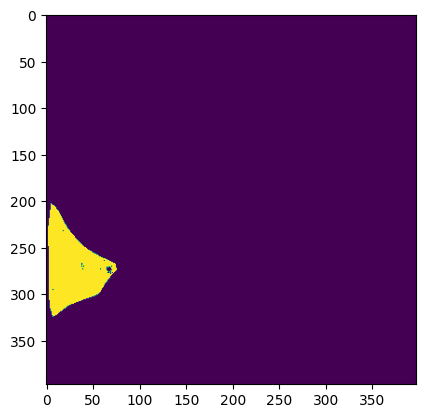

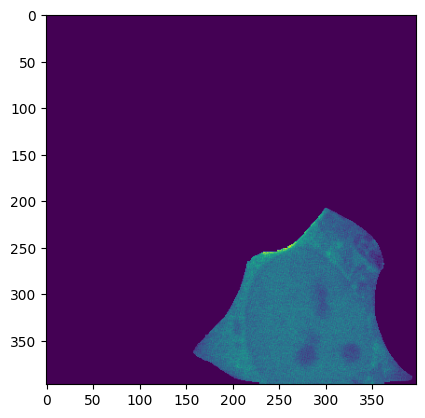

custom thresh
2


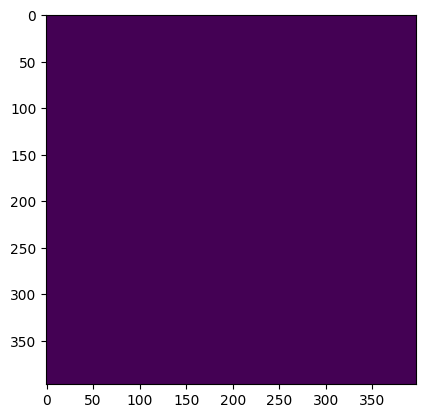

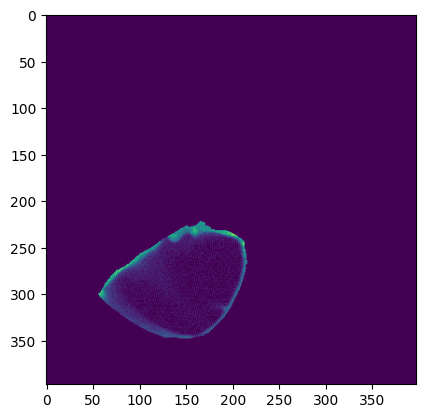

custom thresh
3


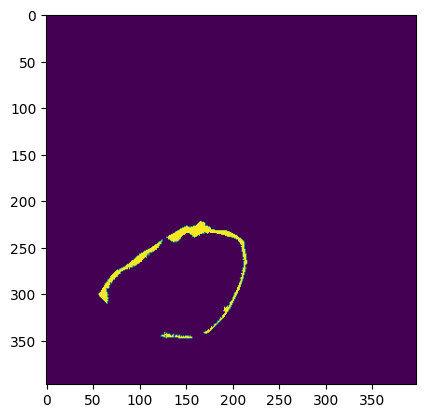

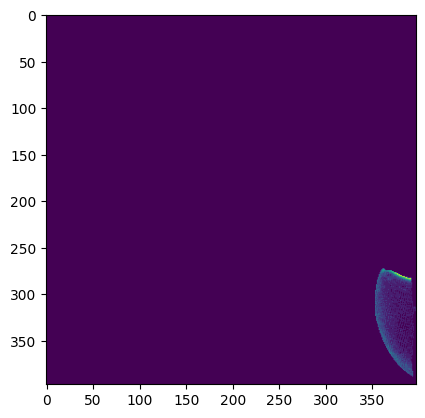

custom thresh
1


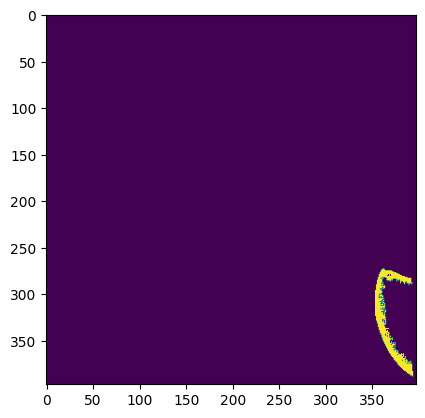

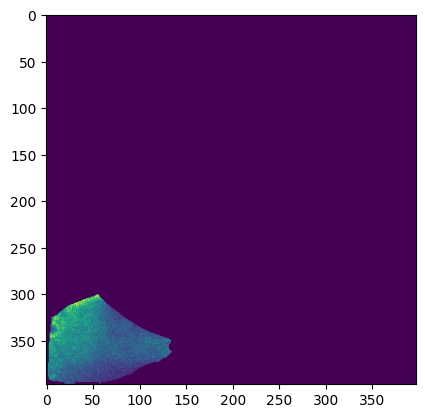

0.999


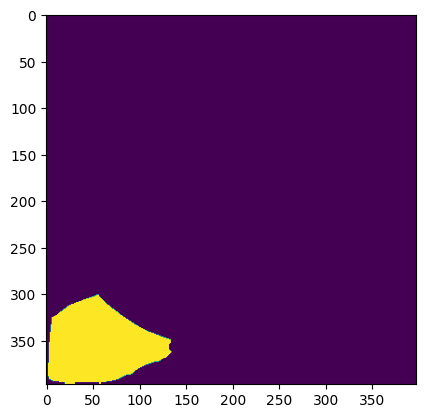

In [ ]:
MIN_INCLUSION_SIZE = 10
MAX_INCLUSION_SIZE = 10000

labelled_cells = skimage.measure.label(cellpose_masks)

for cell in skimage.measure.regionprops(labelled_cells):
    # skip tiny regions likely to be noise
    if cell.area < 100:
        continue
    # mask for single cell
    cell_mask = labelled_cells == cell.label

    # to view each individual cell's area of the original image
    applied_mask = frap_slice * cell_mask
    plt.imshow(applied_mask)
    plt.show()

    # preserve only the image under the single cell mask
    applied_mask_blurred = skimage.filters.gaussian(frap_slice, sigma=1) * cell_mask
    # remove values outside of the cell mask
    applied_mask_eliminate_background = applied_mask_blurred[applied_mask_blurred > 0]
    # normalize the area under the single cell 
    applied_mask_eliminate_background = (applied_mask_eliminate_background - np.min(applied_mask_eliminate_background)) / (np.max(applied_mask_eliminate_background) - np.min(applied_mask_eliminate_background))

    # optionally, can check if the cell contains any of the subcellular structures and skip if not
    # this is done by observing the skew in the distribution of fluoresence via the upper quartile
    q3 = np.percentile(applied_mask_eliminate_background, 75)
    hist, bin_edges = np.histogram(applied_mask_eliminate_background, bins='fd') # fd = freedman diachonis rule
    
    applied_mask = frap_slice * cell_mask # image under single cell mask

    # Decide on thresholding strategy based on upper quartile
    if q3 < 0.4 and len(bin_edges) > 20:
        threshold = max(skimage.filters.threshold_otsu(applied_mask), 0.5)
    elif q3 >= 0.9:
        threshold = 1  # very high, to exclude everything
    else:
        threshold = 0.999  # conservatively high

    print(threshold)

    # Apply threshold and size-based filters
    inclusions = applied_mask > threshold
    inclusions = skimage.morphology.remove_small_objects(inclusions, min_size=MIN_INCLUSION_SIZE)
    inclusions = inclusions ^ skimage.morphology.remove_small_objects(inclusions, min_size=MAX_INCLUSION_SIZE)

    plt.imshow(inclusions)
    plt.show()

    
